<p style="border: 1px solid #e7692c; border-left: 15px solid #e7692c; padding: 10px; text-align:justify;">
    <strong style="color: #e7692c">Tip.</strong> <a style="color: #000000;" href="https://nbviewer.jupyter.org/github/PacktPublishing/Hands-On-Computer-Vision-with-TensorFlow-2/blob/master/Chapter06/ch6_nb1_discover_autoencoders.ipynb" title="View with Jupyter Online">Click here to view this notebook on <code>nbviewer.jupyter.org</code></a>. 
    <br/>These notebooks are better read there, as Github default viewer ignores some of the formatting and interactive content.
    </p>

<table style="font-size: 1em; padding: 0; margin: 0;">
    <tr style="vertical-align: top; padding: 0; margin: 0;background-color: #ffffff">
        <td style="vertical-align: top; padding: 0; margin: 0; padding-right: 15px;">
    <p style="background: #363636; color:#ffffff; text-align:justify; padding: 10px 25px;">
        <strong style="font-size: 1.0em;"><span style="font-size: 1.2em;"><span style="color: #e7692c;">Hands-on</span> Computer Vision with TensorFlow 2</span><br/>by <em>Eliot Andres</em> & <em>Benjamin Planche</em> (Packt Pub.)</strong><br/><br/>
        <strong>> Chapter 6: Enhancing and Segmenting Images </strong><br/>
    </p>

<h1 style="width: 100%; text-align: left; padding: 0px 25px;"><small style="color: #e7692c;">
    Notebook 1:</small><br/>Discovering Auto-Encoders</h1>
<br/>
<p style="border-left: 15px solid #363636; text-align:justify; padding: 0 10px;">
    In Chapter 6 of the book, we introduced <em><strong>encoders-decoders</em></strong> and their variant the <em><strong>auto-encoders</em></strong>. We detailed how auto-encoders' goal is to properly encode and then decode images without impacting their quality, despite their bottleneck (their latent space of lower dimensionality).
<br/><br/>
In this first notebook for Chapter 6, we will present how to build a simple fully-connected encoder-decoder, and how to apply it to the auto-encoding of <em>MNIST</em> images. We will finally demonstrate how this network can be used after training to embed the dataset and highlight its structure.
</p>
<br/>
<p style="border-left: 15px solid #e7692c; padding: 0 10px; text-align:justify;">
    <strong style="color: #e7692c;">Tip.</strong> The notebooks shared on this git repository illustrate some notions from the book "<em><strong>Hands-on Computer Vision with TensorFlow 2</strong></em>" written by Eliot Andres and Benjamin Planche, published by Packt. If you enjoyed the insights shared here, <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!"><strong>please consider acquiring the book!</strong></a>
<br/><br/>
The book provides further guidance for those eager to learn about computer vision and to harness the power of TensorFlow 2 and Keras to build efficient recognition systems for object detection, segmentation, video processing, smartphone applications, and more.</p>
        </td>
        <td style="vertical-align: top; padding: 0; margin: 0; width: 280px;">
    <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Learn more about the book!" target="_blank">
        <img src="../banner_images/book_cover.png" width=280>
    </a>
    <p style="background: #e7692c; color:#ffffff; padding: 10px; text-align:justify;"><strong>Leverage deep learning to create powerful image processing apps with TensorFlow 2 and Keras. <br/></strong>Get the book for more insights!</p>
    <ul style="height: 32px; white-space: nowrap; text-align: center; margin: 0px; padding: 0px; padding-top: 10px;">
    <li style="display: block;height: 100%;float: left;vertical-align: middle;margin: 0 25px 10px;padding: 0px;">
        <a href="https://www.amazon.com/Hands-Computer-Vision-TensorFlow-processing/dp/1788830644" title="Get the book on Amazon (paperback or Kindle version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_amazon.png" width="75px">
        </a>
    </li>
    <li style="display: inline-block;height: 100%;vertical-align: middle;float: right;margin: -5px 25px 10px;padding: 0px;">
        <a href="https://www.packtpub.com/application-development/hands-computer-vision-tensorflow-2" title="Get your Packt book (paperback, PDF, ePUB, or MOBI version)!" target="_blank">
        <img style="vertical-align: middle; max-width: 72px; max-height: 32px;" src="../banner_images/logo_packt.png" width="75px">
        </a>
    </li>
    </ul>
        </td>
        </tr>
        </table>

In [1]:
import tensorflow as tf
import os
import math
import numpy as np

# Some hyper-parameters:
batch_size  = 128           # Images per batch (reduce/increase according to the machine's capability)
num_epochs  = 60            # Max number of training epochs
random_seed = 42            # Seed for some random operations, for reproducibility

## Preparing the Dataset

By now, we should be quite familiar with the [MNIST](http://yann.lecun.com/exdb/mnist) dataset[$^1$](#ref) (c.f. Chapters 1, 2, 3, and their respective notebooks). We prepare the dataset as done previously:

In [ ]:
# !pip install tensorflow-datasets # Uncomment to install the module

In [2]:
import tensorflow_datasets as tfds

mnist_builder = tfds.builder("mnist")
mnist_builder.download_and_prepare()

mnist_info = mnist_builder.info
print(mnist_info)

tfds.core.DatasetInfo(
    name='mnist',
    version=1.0.0,
    description='The MNIST database of handwritten digits.',
    urls=['http://yann.lecun.com/exdb/mnist/'],
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10)
    },
    total_num_examples=70000,
    splits={
        'test': <tfds.core.SplitInfo num_examples=10000>,
        'train': <tfds.core.SplitInfo num_examples=60000>
    },
    supervised_keys=('image', 'label'),
    citation='"""
        @article{lecun2010mnist,
          title={MNIST handwritten digit database},
          author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
          journal={ATT Labs [Online]. Available: http://yann. lecun. com/exdb/mnist},
          volume={2},
          year={2010}
        }
        
    """',
)



In [3]:
import functools

def _prepare_data_fn(features, target='label', flatten=True,
                     return_batch_as_tuple=True, seed=None):
    """
    Resize image to expected dimensions, and opt. apply some random transformations.
    :param features:              Data
    :param target                 Target/ground-truth data to be returned along the images
                                  ('label' for categorical labels, 'image' for images, or None)
    :param flatten:               Flag to flatten the images, from (28, 28, 1) to (784,)
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed:                  Seed for random operations
    :return:                      Processed data
    """
    
    # Tensorflow-Dataset returns batches as feature dictionaries, expected by Estimators.
    # To train Keras models, it is more straightforward to return the batch content as tuples.
    
    image = features['image']
    # Convert the images to float type, also scaling their values from [0, 255] to [0., 1.]:
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    if flatten:
        is_batched = len(image.shape) > 3
        flattened_shape = (-1, 784) if is_batched else (784,)
        image = tf.reshape(image, flattened_shape)
        
    if target is None:
        return image if return_batch_as_tuple else {'image': image}
    else:
        features['image'] = image
        return (image, features[target]) if return_batch_as_tuple else features

def get_mnist_dataset(phase='train', target='label', batch_size=32, num_epochs=None, 
                      shuffle=True, flatten=True, return_batch_as_tuple=True, seed=None):
    """
    Instantiate a CIFAR-100 dataset.
    :param phase:                 Phase ('train' or 'val')
    :param target                 Target/ground-truth data to be returned along the images
                                  ('label' for categorical labels, 'image' for images, or None)
    :param batch_size:            Batch size
    :param num_epochs:            Number of epochs (to repeat the iteration - infinite if None)
    :param shuffle:               Flag to shuffle the dataset (if True)
    :param flatten:               Flag to flatten the images, from (28, 28, 1) to (784,)
    :param return_batch_as_tuple: Flag to return the batch data as tuple instead of dict
    :param seed:                  Seed for random operations
    :return:                      Iterable Dataset
    """

    assert(phase == 'train' or phase == 'test')
    
    prepare_data_fn = functools.partial(_prepare_data_fn, return_batch_as_tuple=return_batch_as_tuple,
                                        target=target, flatten=flatten, seed=seed)

    mnist_dataset = mnist_builder.as_dataset(split=tfds.Split.TRAIN if phase =='train' else tfds.Split.TEST)
    mnist_dataset = mnist_dataset.repeat(num_epochs)
    if shuffle:
        mnist_dataset = mnist_dataset.shuffle(10000, seed=seed)
    mnist_dataset = mnist_dataset.batch(batch_size)
    mnist_dataset = mnist_dataset.map(prepare_data_fn, num_parallel_calls=4)
    mnist_dataset = mnist_dataset.prefetch(1)
    
    return mnist_dataset

In [4]:
# Number of classes:
num_classes = mnist_info.features['label'].num_classes

# Number of images:
num_train_imgs = mnist_info.splits['train'].num_examples
num_val_imgs = mnist_info.splits['test'].num_examples

train_steps_per_epoch = math.ceil(num_train_imgs / batch_size)
val_steps_per_epoch   = math.ceil(num_val_imgs / batch_size)

train_mnist_dataset = get_mnist_dataset(
    phase='train', target='image', batch_size=batch_size, num_epochs=num_epochs, 
    shuffle=True, flatten=True, seed=random_seed)

val_mnist_dataset = get_mnist_dataset(
    phase='test', target='image', batch_size=batch_size, num_epochs=1, 
    shuffle=False, flatten=True, seed=random_seed)

input_shape = mnist_info.features['image'].shape
flattened_input_shape = [np.prod(input_shape)]

## Building a Simple Auto-Encoder

As mentioned in the chapter, an auto-encoder is composed of two modules:

- An **_encoder_**, which converts the input images into **_codes_**, tensors of lower dimensionality;
- A **_decoder_**, which receives the encoder's codes and try to recover the original images from them.

To demonstrate how auto-encoders can compress then recover data, we will define the _codes_ as 32-dimensional vectors (while the MNIST images are 28 * 28 = 784-dimensional):

In [5]:
code_size = 32

Let us know create a simple fully-connected auto-encoder. We will use, e.g., 3 dense layers for the encoder, slowly decreasing the dimensionality of the input to `code_size`. We will then add some layers for the decoder to upsample back to the original dimensions:


In [6]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

inputs = Input(shape=flattened_input_shape, name='input')

# Encoding layers:
enc_1 = Dense(128, activation='relu', name='enc_dense1')(inputs)
enc_2 = Dense(64, activation='relu', name='enc_dense2')(enc_1)
code_layer_name = 'enc_dense3'
code = Dense(code_size, activation='relu', name=code_layer_name)(enc_2)

# Decoding layers:
dec_1 = Dense(64, activation='relu', name='dec_dense1')(code)
dec_2 = Dense(128, activation='relu', name='dec_dense2')(dec_1)
decoded = Dense(flattened_input_shape[0], activation='sigmoid', name='dec_dense3')(dec_2)
# note: we use a sigmoid for the last activation, as we want the output values
# to be between 0 and 1, like the input ones.

# Auto-encoder model:
autoencoder = Model(inputs, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320      
_________________________________________________________________
dec_dense3 (Dense)           (None, 784)               101136

In the chapter, we mentioned that while trained together as an auto-encoder, the encoder and the decoder are usually used separately afterwards. Therefore, it is often convenient to define a separate model for each, wrapping up their respective layers.

For the encoder, it is simply a matter of wrapping into a model the layers from input to code:


In [7]:
encoder = Model(inputs, code)
encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
enc_dense1 (Dense)           (None, 128)               100480    
_________________________________________________________________
enc_dense2 (Dense)           (None, 64)                8256      
_________________________________________________________________
enc_dense3 (Dense)           (None, 32)                2080      
Total params: 110,816
Trainable params: 110,816
Non-trainable params: 0
_________________________________________________________________


This `encoder` model takes images as inputs (sharing the same `Input` placeholder as the complete `autoencoder` model) and returns their codes, e.g., for storing.

For the decoder, things are a bit more complex. We want to define a model composed of the auto-encoder's decoding layers, which would take for inputs codes provided by us and return the corresponding images.
The problem is that in our `autoencoder` model, the decoding layers are linked to the encoding ones. We want them instead to be connected to a new `Input`, representing our user-provided codes. For that, we need to fetch the decoding layers and build a new graph with them, starting from this new input:

In [8]:
input_code = Input(shape=(code_size,), name='input_code')

num_decoder_layers = 3 # c.f. code above
dec_i = input_code
for i in range(num_decoder_layers, 0, -1): # Iterate from 2 to 0 (excluded):
    # We get the decoder layers from the auto-encoder models, one by one:
    dec_layer = autoencoder.layers[-i]
    # Then we apply each layer to the new data, to construct a new graph 
    # with the same parameters:
    dec_i = dec_layer(dec_i)

decoder = Model(input_code, dec_i)
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_code (InputLayer)      [(None, 32)]              0         
_________________________________________________________________
dec_dense1 (Dense)           (None, 64)                2112      
_________________________________________________________________
dec_dense2 (Dense)           (None, 128)               8320      
_________________________________________________________________
dec_dense3 (Dense)           (None, 784)               101136    
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


## Training and Monitoring

Before going through the training, we will set up some useful tools to monitor this process.

### PSNR as custom metric

First, we will pick a metric to estimate how well our auto-encoder is recovering the original images. The _**Peak Signal-to-Noise Ration (PSNR)**_ is commonly used, as it measures the quality of a corrupted or recovered signal/image compared to its original version. The higher the value, the closer to the original image... (the value is in decibels, i.e. following a logarithmic scale). In TensorFlow, this metric can be implemented as follow:

In [9]:
def log_n(x, n=10):
    """
    Compute log_n(x), i.e. the log base `n` value of `x`.
    :param x:   Input tensor
    :param n:   Value of the log base
    :return:    Log result
    """
    log_e = tf.math.log(x)
    div_log_n = tf.math.log(tf.constant(n, dtype=log_e.dtype))
    return log_e / div_log_n


def psnr(img_a, img_b, max_img_value=255):
    """
    Compute the PSNR (Peak Signal-to-Noise Ratio) between two images.
    :param img_a:           Image A
    :param img_b:           Image B
    :param max_img_value:   Maximum possible pixel value of the images
    :return:                PSNR value
    """
    mse = tf.reduce_mean((img_a - img_b) ** 2)
    return 20 * log_n(max_img_value, 10) - 10 * log_n(mse, 10)

This code is mostly for teaching purpose, as TensorFlow actually provides an implementation of this metric: [`tf.image.psnr(a, b, max_val)`](https://www.tensorflow.org/api_docs/python/tf/image/psnr). 

Still, let us use our implementation for now. We wrap it to fit Keras interface for metrics (c.f. previous notebooks): 


In [10]:
import functools

psnr_metrics = functools.partial(psnr, max_img_value=1.)
psnr_metrics.__name__ = 'psnr'

### Custom callback for monitoring

To be fancy and play a bit more with Keras API, we will also define a custom callback. We have been using various pre-defined callbacks in the previous chapters, and even implemented a simple logging callback in Chapter 4. This time, we will implement our own, inheriting from the abstract `Callback` class. This class defines an interface composed of several methods which will be called by Keras along the training (before each epoch, before each batch iteration, after each batch iteration, etc.).

For demonstration, we will implement a callback which plots the training losses/metrics and updates the figure after each epoch:

In [11]:
%matplotlib notebook
import matplotlib.pyplot as plt
import math

class DynamicPlotCallback(tf.keras.callbacks.Callback):
        
    def on_train_begin(self, logs={}):
        # This method will be called when the training start.
        # Therefore, we use it to initialize some elements for our Callback:
        self.logs = dict()
        self.fig, self.ax = None, None
 
    def on_epoch_end(self, epoch, logs={}):
        # This method will be called after each epoch.
        # Keras will call this function, providing the current epoch number,
        # and the values of the various losses/metrics for this epoch (`logs` dict).
        
        # We add the new log values to the list...
        for key, val in logs.items():
            if key not in self.logs:
                self.logs[key] = []
            self.logs[key].append(val)
        # ... then we plot everything:
        self._plot_logs()
 
    def on_train_end(self, logs={}):
        pass    # our callback does nothing special at the end of the training
 
    def on_epoch_begin(self, epoch, logs={}):
        pass   # ... nor at the beginning of a new epoch
 
    def on_batch_begin(self, batch, logs={}):
        pass   # ... nor at the beginning of a new batch
 
    def on_batch_end(self, batch, logs={}):
        pass   # ... nor after.
    
    def _plot_logs(self):
        # Method to clear the figures and draw them over with new values:
        if self.fig is None: # First call - we initialize the figure:
            num_metrics = len(self.logs) 
            self.fig, self.ax = plt.subplots(math.ceil(num_metrics / 2), 2, figsize=(10, 8))
            self.fig.show()
            self.fig.canvas.draw()
        
        # Plotting:
        i = 0
        for key, val in self.logs.items():
            id_vert, id_hori = i // 2, i % 2
            self.ax[id_vert, id_hori].clear()
            self.ax[id_vert, id_hori].set_title(key)
            self.ax[id_vert, id_hori].plot(val)
            i += 1
        
        #self.fig.tight_layout()
        self.fig.subplots_adjust(right=0.75, bottom=0.25)
        self.fig.canvas.draw()


### Training and results

We now have everything to monitor the training. As explained in the chapter, our auto-encoder will receive the training **images both as inputs and targets** (`x_train`), and will try to minimize a **cross-entropy loss**:

<IPython.core.display.Javascript object>


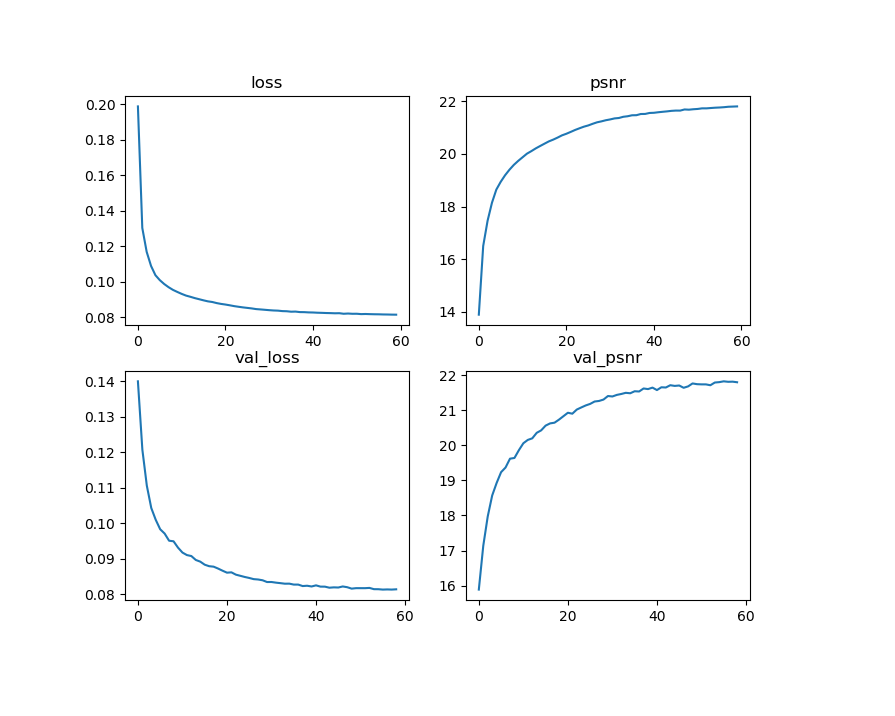

W0328 11:54:30.521862 140301929522944 training_generator.py:228] Your dataset ran out of data; interrupting training. Make sure that your dataset can generate at least `steps_per_epoch * epochs` batches (in this case, 28140 batches). You may need to use the repeat() function when building your dataset.


In [12]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy',
                    metrics=[psnr_metrics])

history = autoencoder.fit(
    train_mnist_dataset, epochs=num_epochs, steps_per_epoch=train_steps_per_epoch,
    validation_data=val_mnist_dataset, validation_steps=val_steps_per_epoch,
    verbose=0, callbacks=[DynamicPlotCallback()])

It seems our network converged. To have a better look, we build a method to show the input/target images and the auto-encoder's results:


In [13]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import numpy as np

def show_pairs(samples_a, samples_b, 
               plot_fn_a="imshow", plot_fn_b="imshow"):
    """
    Plot pairs of data
    :param samples_a:   List of samples A
    :param samples_b:   List of samples B
    :param plot_fn_a:   Name of Matplotlib function to plot A (default: "imshow")
    :param plot_fn_b:   Name of Matplotlib function to plot B (default: "imshow")
    :return:            /
    """
    assert(len(samples_a) == len(samples_b))
    num_images = len(samples_a)
    
    figure = plt.figure(figsize=(num_images, 2))
    grid_spec = gridspec.GridSpec(1, num_images)
    for i in range(num_images):
        
        grid_spec_i = gridspec.GridSpecFromSubplotSpec(
            2, 1, subplot_spec=grid_spec[i], hspace=0)
        
        # Drawing image A:
        ax_img = figure.add_subplot(grid_spec_i[0])
        getattr(ax_img, plot_fn_a)(samples_a[i])
        plt.gray()
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
        
        # Drawing image B:
        ax_img = figure.add_subplot(grid_spec_i[1])
        getattr(ax_img, plot_fn_b)(samples_b[i])
        plt.gray()
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
        
    # plt.tight_layout()
    plt.show()

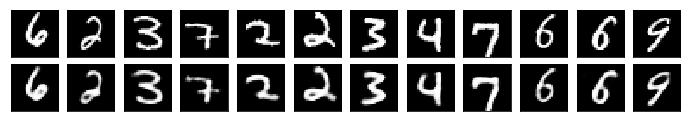

In [19]:
num_show = 12

x_test_sample = next(val_mnist_dataset.__iter__())[0][:num_show].numpy()
x_decoded = autoencoder.predict_on_batch(x_test_sample)
show_pairs(x_test_sample.reshape(num_show, *input_shape[:2]), 
           x_decoded.reshape(num_show, *input_shape[:2]))


As we can see, results are indeed aright (though maybe a bit blurry). Despite its low-dimensional bottleneck and simplistic architecture, our network can nicely recover the digits.


## Embedding and Visualizing Datasets with Auto-Encoders


Since we defined an `encoder` model, we can also plot the images and their corresponding 32-dimensional codes.


### Code visualization

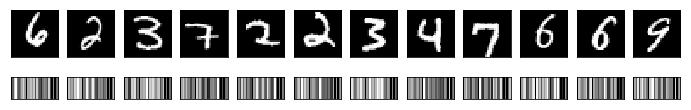

In [21]:
x_encoded = encoder.predict_on_batch(x_test_sample)

# We scale up the code, to better visualize it:
x_encoded_show = np.tile(x_encoded.reshape(num_show, 1, code_size), (1, 15, 1))

show_pairs(x_test_sample.reshape(num_show, *input_shape[:2]), 
           x_encoded_show, plot_fn_b="matshow")

While interesting to visualize, these codes don't tell us much about the data at first glance. With still 32 dimensions, it is **hard to interpret** these features extracted by the encoder, even though they seem to contain enough information for the decoder to recover the original images from them.

### Dataset embedding with t-SNE

To make this 32-dimensional latent space more understandable, we will use a method to find a 2D projection which best preserves the data distribution. Applying such a method to the MNIST codes, we could then visualize the complete dataset as a 2D scatter plot. 

While multiple solutions exist to find interesting projections given a multi-dimensional dataset (PCA, LDA, etc.), we will use here **_t-SNE_**. The _t-Distributed Stochastic Neighbor Embedding_[$^2$](#ref) is an unsupervised technique developed by Laurens van der Maatens and Geoffrey Hinton in 2008. Given a dataset, this method returns a non-linear projection which tries to maximize the distance between all the elements after projection. This is a really useful tool, and multiple implementation already exist.

We will use here a version provided by `scikit`:

In [22]:
# !pip install scikit-learn  # uncomment to install the module if it isn't done yet.
from sklearn.manifold import TSNE
# Creating a t-SNE instance to project our codes into 2D elements:
tsne = TSNE(n_components=2, verbose=1, random_state=0)

After converting the whole dataset into codes, we apply this method to them, and finally visualize them all together as a scatter plot:

In [23]:
_, (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_test = x_test / 255.0
x_test = x_test.reshape(x_test.shape[0], *flattened_input_shape)

x_encoded = encoder.predict_on_batch(x_test)
x_2d = tsne.fit_transform(x_encoded)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.013s...
[t-SNE] Computed neighbors for 10000 samples in 4.971s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 4.024734
[t-SNE] KL divergence after 250 iterations with early exaggeration: 85.299362
[t-SNE] KL divergence after 1000 iterations: 1.773399


/home/benjamin/anaconda3/envs/tf2/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


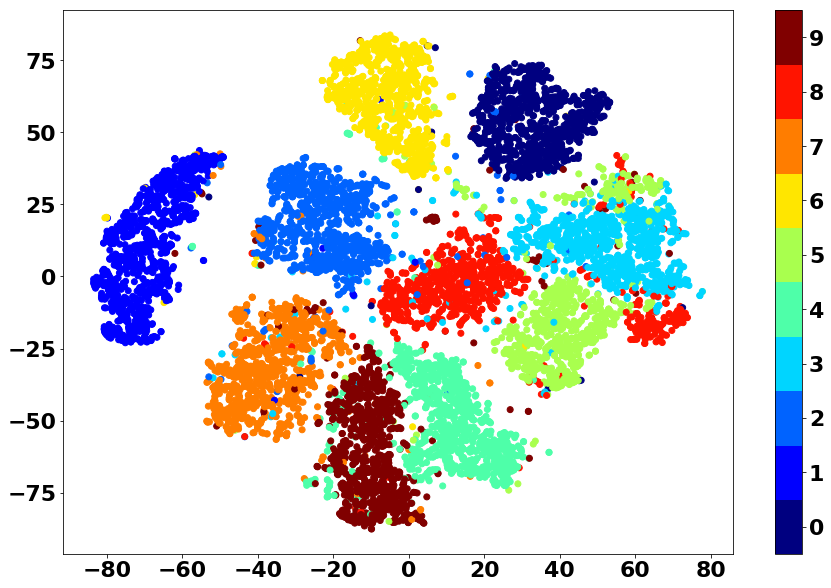

In [24]:
import matplotlib

font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
figure = plt.figure(figsize=(15, 10))
plt.scatter(x_2d[:, 0], x_2d[:, 1], # 2D image projections
            c=y_test                # per-class colors
            ,cmap=plt.cm.get_cmap("jet", num_classes) 
            # replace "jet" with "plasma" for colors more consistent when printed grayscale
           )
plt.colorbar(ticks=range(num_classes))
plt.clim(-0.5, num_classes - 0.5)
plt.show()

Each point represents a digit image, as encoded by our model. As we can see, the codes contain some features which clearly could be used to distinguish between classes, **even though at no point the network was aware of the image classes**. The auto-encoder managed to uncover by itself some similarities and structures in the dataset, to better compress the images without losing information.

## Conclusion

Through this notebook, we got acquainted with auto-encoders, and how networks can be applied to pixel-level predictions. In the process, we presented and implemented various tools (custom metrics, losses, and callbacks, modular models, etc.) which will come handy for the next notebooks and chapters.

<a id="ref"></a>
#### References

1. LeCun, Y., Cortes, C., Burges, C., 2010. MNIST handwritten digit database. AT&T Labs [Online]. Available: http://yann.lecun.com/exdb/mnist 2, 18.
2. Maaten, L. van der, Hinton, G., 2008. Visualizing data using t-SNE. Journal of machine learning research 9, 2579–2605.